# **Tutorial 3: In Silico Perturbation**
In this tutorial, we demonstrate how to perform **in silico perturbation** using the trained SIDISH model. In silico perturbation allows us to computationally "knock out" (or significantly reduce) the expression of individual genes – or pairs of genes – and observe how such perturbations affect the distribution of high-risk cells in our single-cell dataset. Specifically, SIDISH recalculates which cells transition from a high-risk state to background (or vice versa) upon the simulated gene knockouts. This approach provides an effective way to identify potential therapeutic targets: if knocking out a particular gene (or gene pair) causes many high-risk cells to become background cells, that gene(s) may be a promising avenue for therapeutic intervention.


## **Step 1: Import libraries**

In [1]:
import SIDISH as sidish
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import  torch
import random
import os
import matplotlib.pyplot as plt

/Users/admin/miniconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set Seeds

In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(1)
ite = 0
# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the seed setting function
set_seed(seed)

## **Step 2: Reload the saved data and SIDISH model**

### **2.1 Reload saved single-cell data**

In [3]:
path = "../data/LUNG/"
adata = sc.read_h5ad("{}adata_SIDISH.h5ad".format(path))

# Read survival+bulk dataset
bulk = pd.read_csv("../data/processed_bulk.csv", index_col=0)

### **2.2 Reload trained SIDISH**

In [4]:
sdh = sidish.SIDISH(adata, bulk, "cuda", seed=ite)
sdh.init_Phase1(225, 20, 32, [512, 128], 512, "Adam", 1.0e-4, 1e-4, 0)
sdh.init_Phase2(500, 128, 1e-4, 0, 0.2, 256)
sdh.reload(path)

SIDISH No spatial graph used. Proceeding with dense VAE.
########################################## Using Dense VAE ##########################################
✅ Reload complete – VAE and DeepCox restored


### **2.3 Reload High-Risk cells threshold in final iteration of trained SIDISH**

In [5]:
sdh.get_percentille(0.95)

0.44949187154847925


0.44949187154847925

## **Step 3: Perform perturbation**

The `run_Perturbation()` function systematically simulates single-gene knockouts in the trained SIDISH model. For each gene in your dataset:
1. SIDISH reduces that gene’s expression (in practice, sets it to near zero) within the relevant high-risk cell subpopulations.
2. It then recalculates the predicted risk distribution to determine how many high-risk cells “convert” to background cells (or vice versa).
3. It records the magnitude of these conversions as well as the statistical significance (p-values).

As output, `run_Perturbation()` provides four dictionaries:
- **percent_change**: Binary perturbation score – the percentage shift in high-risk cells after each gene knockout.
- **p_flip**: The statistical significance of the shift for each gene.
- **delta_change**: Continuous perturbation score – the average shift in predicted risk scores across all cells after perturbation.
- **p_score**: Statistical significance of the continuous shifts.


In [6]:
percent_change, delta_change, p_flip, p_score = sdh.run_Perturbation()

Stats: 100%|██████████| 1208/1208 [00:49<00:00, 24.62it/s]


### **Interpreting Perturbation Scores**
**Binary Perturbation Score (percentage_dict)**  

$$
S_T^{\text{binary}} = \frac{\# \text{cells flipped (High-Risk → Background)}}{N}
$$  

- **High positive values** = strong candidate therapeutic targets (knockout reduces High-Risk burden).  
- **Near zero** = little to no effect.  





You can then use `plot_top_perturbed_genes()` to visualize the top genes most effective at reducing the number of high-risk cells. By default, here we plot the top 30 genes most strongly associated with shifting high-risk cells into background. These genes are of particular interest as they may represent key vulnerabilities within the high-risk subpopulations.


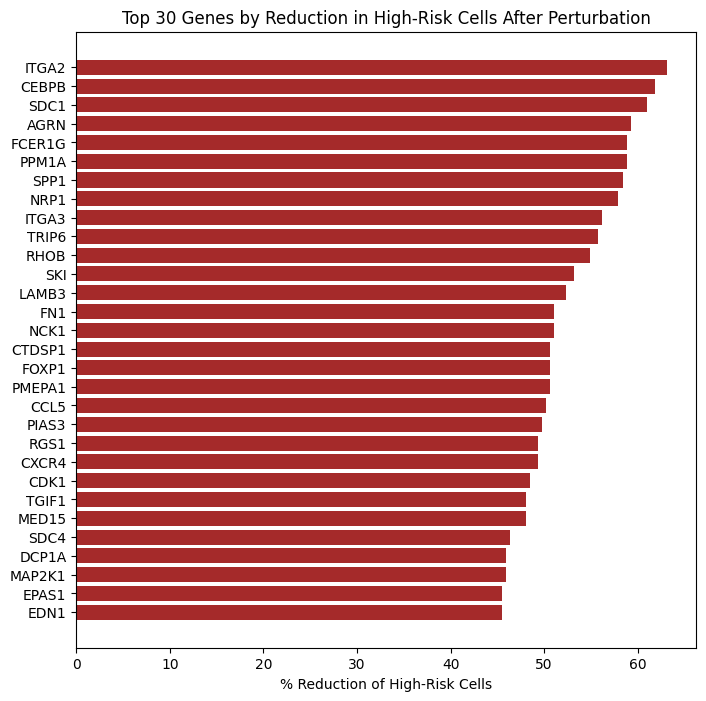

In [7]:
sdh.plot_top_perturbed_genes(percent_change, top_n=30, type="percent")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/admin/Library/CloudStorage/OneDrive-McGillUniversity/PhD/PhD 3/SIDISH/SIDISH/SIDISH.py:644: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(self.adata, resolution=resolution, random_state=self.seed)


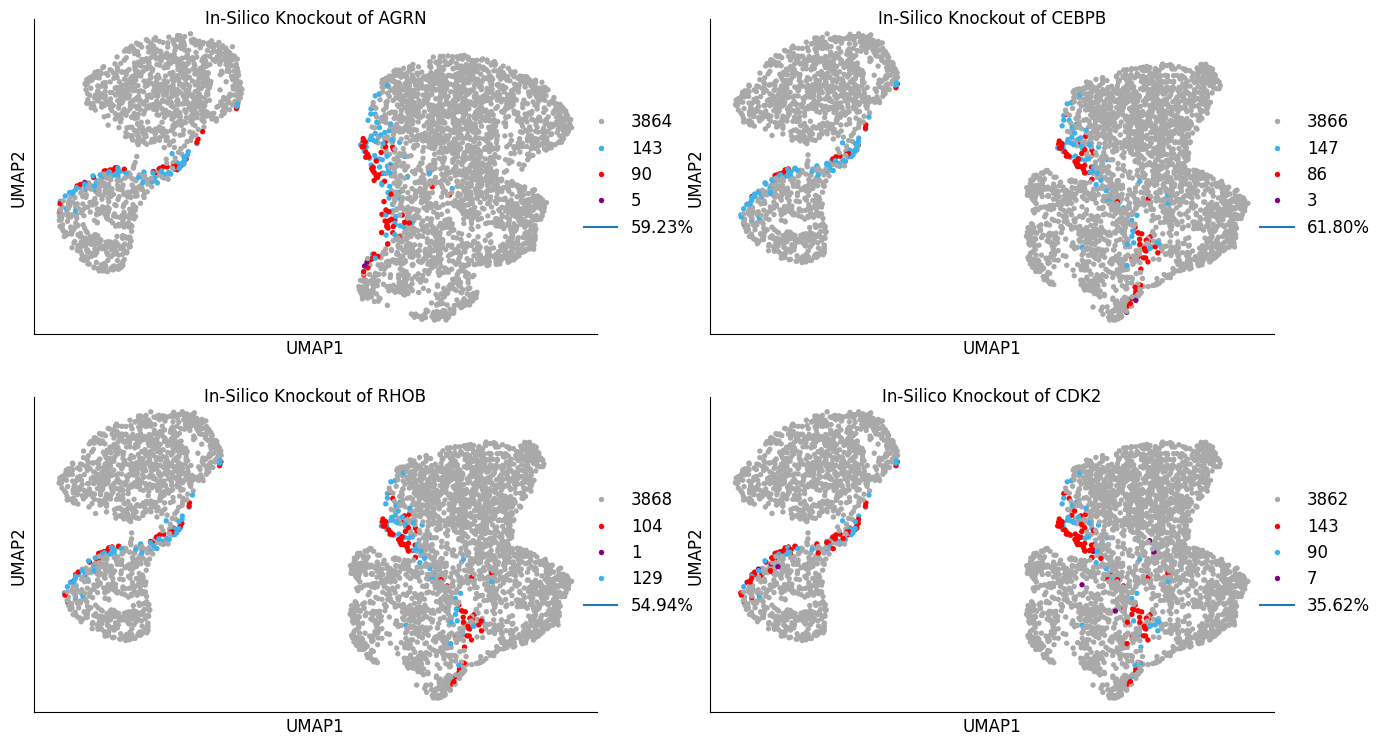

In [8]:
sdh.plot_perturbation_UMAP_default(['AGRN', 'CEBPB', "RHOB", 'CDK2'], resolution=0.8, celltype=False)

### **Interpreting Perturbation Scores**
**Continuous Perturbation Score (delta_dict)**  
$$
S_T^{\text{continuous}} = \frac{1}{N} \sum_{i=1}^{N} \big(Y_i - Y'_i\big)
$$  

- $Y_i$ = cell *i*’s risk score before perturbation  
- $Y'_i$ = cell *i*’s risk score after perturbation  
- $N$ = total cells  


Interpretation:  
- **Positive values** → average risk decreases after knockout (gene supports High-Risk phenotype).  
- **Negative values** → risk increases after knockout (gene may be protective).  
- **Values near zero** → minimal impact.  

👉 Binary scores are best for **clear therapeutic prioritization**, while continuous scores are useful for **capturing subtle shifts** in risk distributions.  

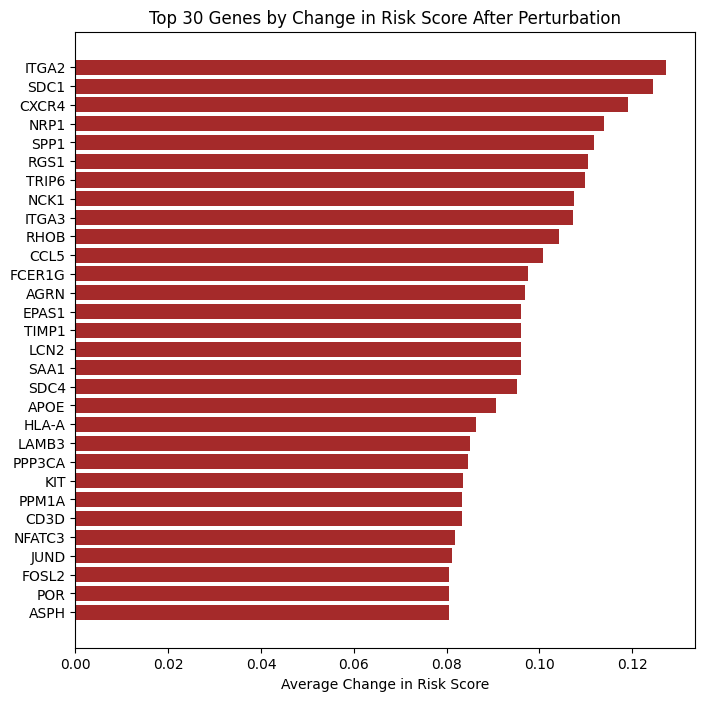

In [9]:
sdh.plot_top_perturbed_genes(delta_change, top_n=30, type="score")

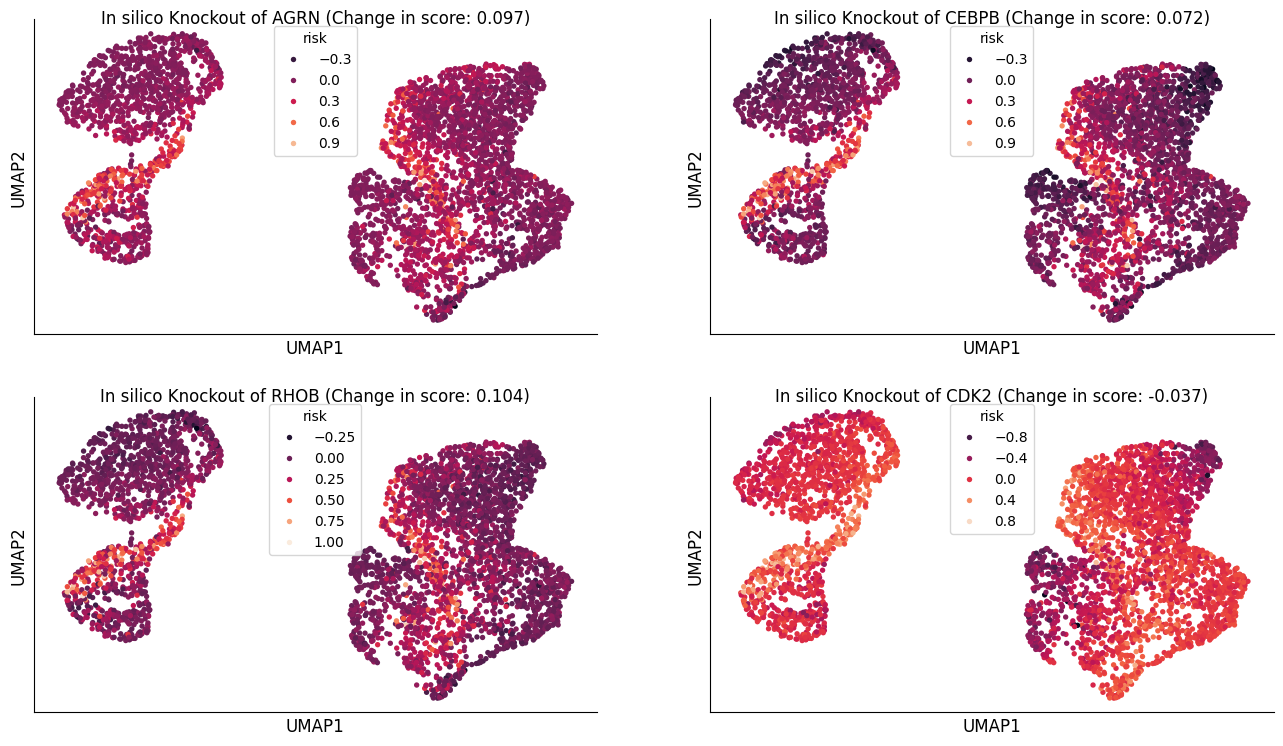

In [10]:
sdh.plot_perturbation_UMAP_differential(['AGRN', 'CEBPB', "RHOB", 'CDK2'], resolution=0.8, celltype=False)

## **Step 4: Run double gene perturbation**
The `run_double_Perturbation()` function extends the idea of single-gene knockouts to pairs of genes, simulating the simultaneous knockout of two genes at a time. This can help identify **synergistic targets**, where inhibiting two genes together yields a far stronger effect on reducing high-risk cells compared to inhibiting either gene alone.

Similar to single-gene knockouts, you get:
- **percentage_double_dict**: The shift in high-risk cells after each gene-pair knockout.
- **pvalue_double_dict**: The statistical significance of this shift.


In [11]:
percent_change_df = pd.DataFrame(list(percent_change.items()), columns=["Genes", "Scores"])
percent_change_df.sort_values(by='Scores', ascending=False, inplace=True)
percent_change_df.Genes.values[:20]

array(['ITGA2', 'CEBPB', 'SDC1', 'AGRN', 'PPM1A', 'FCER1G', 'SPP1',
       'NRP1', 'ITGA3', 'TRIP6', 'RHOB', 'SKI', 'LAMB3', 'FN1', 'NCK1',
       'FOXP1', 'CTDSP1', 'PMEPA1', 'CCL5', 'PIAS3'], dtype=object)

In [12]:
percentage_double_dict, pvalue_double_dict = sdh.run_double_Perturbation(percent_change_df.Genes.values[:20])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


100%|██████████| 380/380 [03:19<00:00,  1.91it/s]


The `plot_double_Perturbation_Heatmap()` function provides a comprehensive heatmap showing how each pair of genes affects the percentage of high-risk cells. Pairs that produce especially large shifts in high-risk cells may be prime candidates for combination therapies.

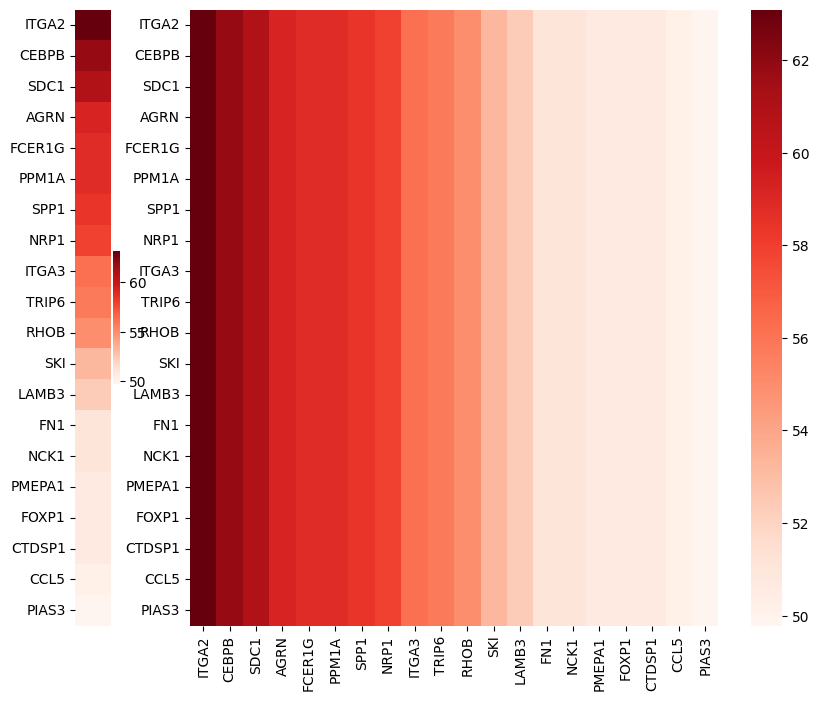

In [13]:
sdh.plot_double_Perturbation_Heatmap(percentage_double_dict)